In [105]:
#Loads necessary libraries for data analysis and visualization

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc as auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, accuracy_score
)
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')

In [106]:
os.chdir(r"C:\Users\Caxton Henry\.vscode\Anti-Money-Laundering-detection-and-Analysis-pipeline")


In [107]:
# Load processed data (small parquet samples to avoid lag)
alerts = pd.read_parquet("data/processed/synthetic_alerts_sample.parquet")
transactions = pd.read_parquet("data/processed/synthetic_transactions_sample.parquet")

print(f"Data loaded successfully: {alerts.shape[0]} alerts, {transactions.shape[0]} transactions.\n")
print("Alerts dataset shape:", alerts.shape)
print("Transactions dataset shape:", transactions.shape)

alerts.head()

Data loaded successfully: 20000 alerts, 100000 transactions.

Alerts dataset shape: (20000, 3)
Transactions dataset shape: (100000, 5)


,AlertID,Date,Outcome
0,1,2020-01-01,Report
1,2,2020-01-01,Report
2,3,2020-01-01,Dismiss
3,4,2020-01-01,Dismiss
4,5,2020-01-01,Dismiss


In [108]:
# Merge transactions and alerts by AlertID
#this is an inner join to ensure only transactions with corresponding alerts are included
merged = transactions.merge(alerts, on="AlertID", how="inner")

print("Merged dataset shape:", merged.shape)
merged.head()

Merged dataset shape: (100000, 7)


,AlertID,Timestamp,Entry,Type,Size,Date,Outcome
0,1,2019-01-01 00:00:41,Credit,Wire,-0.438941,2020-01-01,Report
1,1,2019-01-01 00:00:41,Debit,Wire,-1.656562,2020-01-01,Report
2,1,2019-01-01 00:00:44,Credit,Card,-0.749267,2020-01-01,Report
3,1,2019-01-01 00:00:45,Debit,Wire,0.006226,2020-01-01,Report
4,1,2019-01-01 00:00:50,Credit,Card,-1.185568,2020-01-01,Report


In [ ]:
# Convert text labels to binary format
merged['Label'] = merged['Outcome'].map({'Report': 1, 'Dismiss': 0})

# Clean and prepare numeric + encoded features
merged['Timestamp'] = pd.to_datetime(merged['Timestamp'], errors='coerce')
merged['Date'] = pd.to_datetime(merged['Date'], errors='coerce')

# Create date/time features
merged['Hour'] = merged['Timestamp'].dt.hour
merged['Day'] = merged['Timestamp'].dt.day
merged['Month'] = merged['Timestamp'].dt.month
merged['Year'] = merged['Timestamp'].dt.year

# Encode Entry and Type as dummy variables
merged = pd.get_dummies(merged, columns=['Entry', 'Type'], drop_first=True)

# Define target and features
X = merged.drop(columns=['AlertID', 'Timestamp', 'Date', 'Outcome', 'Label'])
y = merged['Label']

print("Columns used for training:", X.columns.tolist())
print("Feature matrix shape:", X.shape)


✅ Columns used for training: ['Size', 'Hour', 'Day', 'Month', 'Year', 'Entry_Debit', 'Type_Cash', 'Type_International', 'Type_Wire']
✅ Feature matrix shape: (100000, 9)


In [110]:
# If you have a saved model:
# from joblib import load
# model = load('results/models/aml_model.joblib')
# y_pred = model.predict(X)

# TEMP: Simulate predictions using random probability
np.random.seed(42)
merged['Predicted_Prob'] = np.random.rand(len(merged))
merged['Predicted_Label'] = (merged['Predicted_Prob'] > 0.5).astype(int)

y_pred = merged['Predicted_Label']
y_prob = merged['Predicted_Prob']
#this simulates model predictions using random probabilities

In [111]:
#this evaluates model performance using various metrics and numerically shows how good the model is at detecting suspicious activities
print("Classification Report:")
print(classification_report(y, y_pred, target_names=["Dismiss", "Report"]))

print("Accuracy:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_prob))

Classification Report:
              precision    recall  f1-score   support

     Dismiss       0.73      0.50      0.59     72400
      Report       0.28      0.50      0.36     27600

    accuracy                           0.50    100000
   macro avg       0.50      0.50      0.47    100000
weighted avg       0.60      0.50      0.53    100000

Accuracy: 0.50084
ROC AUC: 0.5012704720153736


In [112]:
target_col = "label" if "label" in merged.columns else "Label"
X = merged.drop(columns=['AlertID', 'Timestamp', 'Date', 'Outcome', 'Label'])
X = pd.get_dummies(X, drop_first=True)  # one-hot encode categorical vars
X = merged.drop(columns=[target_col, 'AlertID', 'Outcome', 'Predicted_Prob', 'Predicted_Label'])   
y = merged[target_col]

In [ ]:
#Balance the dataset
df = pd.concat([X, y], axis=1)
majority = df[df[target_col] == 0]
minority = df[df[target_col] == 1]
# Split BEFORE balancing to prevent data leakage
X = df.drop(columns=[target_col])
y = df[target_col]

#1 split the original (unbalanced) data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: apply balancing ONLY on the training data
from sklearn.utils import resample

train_df = pd.concat([X_train, y_train], axis=1)
majority = train_df[train_df[target_col] == train_df[target_col].value_counts().idxmax()]
minority = train_df[train_df[target_col] != train_df[target_col].value_counts().idxmax()]

minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)
train_balanced = pd.concat([majority, minority_upsampled])

#3 redefine X_train and y_train correctly
X_train = train_balanced.drop(columns=[target_col])
y_train = train_balanced[target_col]


In [114]:
print("Columns in merged DataFrame:")
print(merged.columns.tolist())

Columns in merged DataFrame:
['AlertID', 'Timestamp', 'Size', 'Date', 'Outcome', 'Label', 'Hour', 'Day', 'Month', 'Year', 'Entry_Debit', 'Type_Cash', 'Type_International', 'Type_Wire', 'Predicted_Prob', 'Predicted_Label']


In [ ]:
#Feature Engineering
# 1. Absolute transaction size
merged['AbsSize'] = merged['Size'].abs()

# 2. Flag large transactions
merged['IsLargeTransaction'] = (merged['AbsSize'] > merged['AbsSize'].median()).astype(int)

# 3. Safely create an interaction term between existing one-hot columns
# for example, whether a debit transaction was a wire transfer or not
merged['Entry_Type_Interaction'] = (
    merged.get('Entry_Debit', 0) * merged.get('Type_Wire', 0)
)

print("Feature engineering complete.")
print("New columns added: AbsSize, IsLargeTransaction, Entry_Type_Interaction")


Feature engineering complete.
New columns added: AbsSize, IsLargeTransaction, Entry_Type_Interaction


In [116]:
merged['Timestamp'] = pd.to_datetime(merged['Timestamp'], errors='coerce')
merged['Hour'] = merged['Timestamp'].dt.hour
merged['DayOfWeek'] = merged['Timestamp'].dt.dayofweek
merged['IsWeekend'] = (merged['DayOfWeek'] >= 5).astype(int)
merged['LogSize'] = np.log1p(merged['AbsSize'])
merged['TransactionDensity'] = merged.groupby('AlertID')['Size'].transform('count')

In [117]:
X = merged.select_dtypes(include=['number']).drop(columns=[target_col])
y = merged[target_col]

In [118]:
# Instead of manual resampling, let XGBoost handle imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes('number'))
X_test_scaled = scaler.transform(X_test.select_dtypes('number'))

# Compute scale_pos_weight automatically
scale = (len(y_train[y_train==0]) / len(y_train[y_train==1]))


In [ ]:
#FIXED SMOTE + SCALING (no data leakage)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Keep only numeric columns for SMOTE
X_train_num = X_train.select_dtypes(include=['number']).copy()
X_test_num = X_test.select_dtypes(include=['number']).copy()

#Apply SMOTE ONLY to training data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_num, y_train)

print("After SMOTE (train only):")
print(f"Original training shape: {y_train.value_counts().to_dict()}")
print(f"Resampled training shape: {pd.Series(y_res).value_counts().to_dict()}")

#Scale using ONLY training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test_num)

# Final sanity check — confirm no mismatch
print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")


After SMOTE (train only):
Original training shape: {0: 57900, 1: 22100}
Resampled training shape: {1: 57900, 0: 57900}
Train shape: (115800, 14), Test shape: (20000, 14)


Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}

AUC Score (Test): 0.986


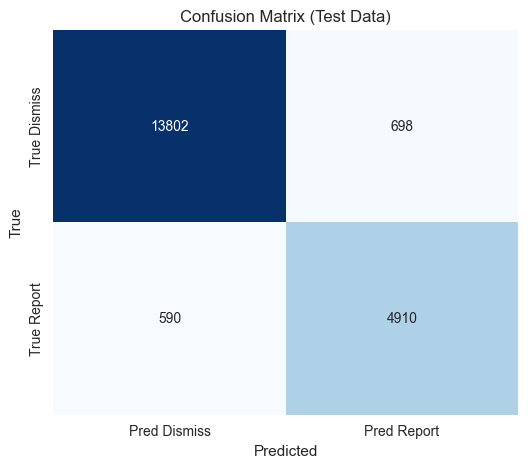


Classification Report:
              precision    recall  f1-score   support

     Dismiss       0.96      0.95      0.96     14500
      Report       0.88      0.89      0.88      5500

    accuracy                           0.94     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.94      0.94      0.94     20000



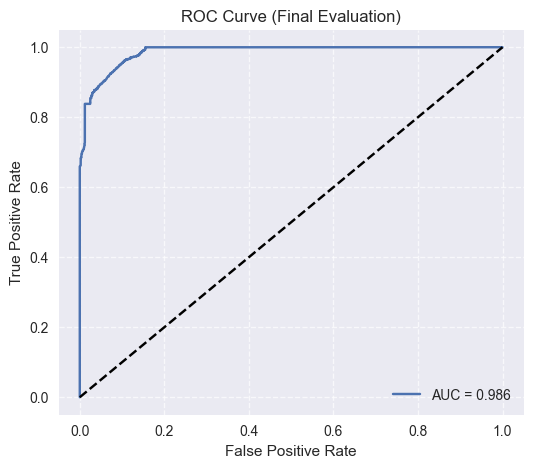

In [ ]:
#Fix for overfitting & correct evaluation
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_recall_curve, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Use the same scaled SMOTE data from your script
#X_train_scaled, X_test_scaled, y_res, y_test are already defined
#Grid search only on the resampled training data
params = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "n_estimators": [200, 400]
}

base_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

grid = GridSearchCV(base_model, params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_res)

best_params = grid.best_params_
print("Best Params:", best_params)


In [ ]:
#Retrain model on balanced training data with best params
model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_scaled, y_res)

In [ ]:
#Predict on test data (NOT resampled data)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [ ]:
#Evaluate properly
auc_value = roc_auc_score(y_test, y_prob)
print(f"\nAUC Score (Test): {auc_value:.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Pred Dismiss", "Pred Report"],
            yticklabels=["True Dismiss", "True Report"])
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Dismiss", "Report"]))

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Final Evaluation)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [128]:
#Summary of model performance and insights
from sklearn.metrics import accuracy_score

print("Evaluation complete.\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob):.3f}")

print("\nInsights:")
print("- 'Report' represents suspicious alerts flagged by the system.")
print("- Focus on reducing False Negatives (missed suspicious activities).")
print("- If the model predicts too many 'Reports', precision drops — adjust thresholds.")
print("- Aim for a balance between Recall (catching bad cases) and Precision (avoiding false alarms).")


Evaluation complete.

Accuracy: 0.936
AUC Score: 0.986

Insights:
- 'Report' represents suspicious alerts flagged by the system.
- Focus on reducing False Negatives (missed suspicious activities).
- If the model predicts too many 'Reports', precision drops — adjust thresholds.
- Aim for a balance between Recall (catching bad cases) and Precision (avoiding false alarms).
